# Imports

In [1]:
from subprocess import call
from time import time
import warnings
warnings.filterwarnings('ignore')
import os, sys, time, datetime, string, glob, re
import itertools

import scipy as sp
import numpy as np
import pandas as pd

import theano as thno
import theano.tensor as T
import xgboost as xgb
from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

# plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# seaborn
import seaborn as sns
sns.set(style="dark", palette="muted")
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Functions

In [2]:
def logloss(est, X, Y):
    probs = est.predict_proba(X)
    logloss = 0.0
    for i in range(len(Y)):
        tmp_y = [0.,0.,0.]
        tmp_y[Y[i]]=1.
        v_probs = probs[i]
        if any(v_probs)==1.:
            v_probs = np.asarray([np.max([np.min([p,1-1e-15]),1e-15]) for p in v_probs])
        logloss += np.sum(np.asarray(tmp_y)*np.log(np.asarray(v_probs)))
    logloss = -logloss/len(Y)
    return logloss

In [3]:
def scorer_logloss(est, X, Y):
    return 1./logloss(est,X, Y)

In [4]:
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [38]:
class MyXGBClassifier(object):

    def __init__(self, n_rounds=100, **params):
        self.clf = None
        self.params = params        
        self.n_rounds = n_rounds
        self.dtrain = None

    def fit(self, X, Y):
        num_boost_round = self.n_rounds
        self.dtrain = xgb.DMatrix(X, label=Y)
        self.clf = xgb.train(params=self.params, dtrain=self.dtrain, num_boost_round=num_boost_round)

    def predict(self, X):
        Y = self.clf.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array(y)

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        return self

    def logloss(self, X, Y):
        return logloss(self,X,Y)

    def score(self, X, Y):
        return 1 / logloss(self,X, Y)

In [6]:
def all_combos(attr):
    combos = []
    for i in range(1, len(attr)+1):
        for subset in itertools.combinations(attr, i):
            combos.append(subset)
    return combos

In [7]:
def feature_indices(df, attr):
    idx = {}
    for a in attr:
        idx[a] = [c for c in df.columns if c.startswith(a)]
    return idx

In [8]:
def kscore(y_pred, y_true):
    nrows = y_pred.shape[0]
    y_pred = y_pred + 1e-15
    probs = y_pred[list(range(nrows)), y_true.astype(int)]
    return - np.sum(np.log(probs)) / nrows

In [9]:
def feature_mixer(df, attr, clf_class, **kwargs):
    
    # scoring arrays
    acc = []
    prec = []
    recl = []
    f1 = []
    ks = []
    
    # get attribute combos to explore
    attr_com = all_combos(attr)

    # get these attr as indices
    attr_idx = feature_indices(df, attr)
    
    # labelizer
    lb = preprocessing.LabelBinarizer()
    
    # iterate through all combinations of features
    for a in attr_com:

        # get feature indices
        idxs = []
        for b in a:
            idxs.extend(attr_idx[b])

        # build datasets    
        X = df.ix[:, (idxs)].copy().values
        y = df.fault_severity.values
        y_cat = lb.fit_transform(y)
        y_pred = y.copy()
        y_prob = y_cat.copy().astype(float)
        
        # initialize counters
        mean_acc = 0.0
        mean_prec = 0.0
        mean_recl = 0.0
        mean_f1 = 0.0
        mean_ks = 0.0
        
        # run kfold cv
        kf = cross_validation.StratifiedKFold(y, n_folds=10, shuffle=True)
        for train_index, test_index in kf:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = clf_class(**kwargs)
            clf = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('clf', clf)])
            clf.fit(X_train, y_train)
            y_pred[test_index] = clf.predict(X_test)
            y_prob[test_index] = clf.predict_proba(X_test)
            mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
            mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
            mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
            mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
            mean_ks += kscore(y_prob[test_index], y[test_index])

        # update mean counters
        acc.append(mean_acc / len(kf))
        recl.append(mean_recl / len(kf))
        prec.append(mean_prec / len(kf))
        f1.append(mean_f1 / len(kf))
        ks.append(mean_ks / len(kf))

    # make dataframe
    result = pd.DataFrame({'attr_combo':attr_com, 'accuracy':acc,
                           'precision':prec, 'recall':recl, 'f1':f1,
                           'kscore':ks})
    return result

# Files

In [10]:
# get datadir
import platform
uname = platform.uname()[0]
if uname == 'Linux':
    datadir = '/home/kcavagnolo/ml_fun/telstra/data/'
elif uname == 'Darwin':
    datadir = '/Users/cavagnolo/ml_fun/telstra/data/'
else:
    raise OSError("Unknown system: " + str(uname))

# get files
files = sorted(glob.glob(datadir + '*.csv'))
hdf_file = datadir + 'features.h5'

# reopen hdf store
hdf = pd.HDFStore(hdf_file)

# reload df's
print hdf
df_test = hdf['df_test']
df_train = hdf['df_train']
df_all = hdf['df_all']
hdf.close()

# cols to drop
attribute_drop = ['fault_severity', 'id', 'location', 'is_train']

# col prefixes
attributes = ['event_', 'resource_', 'severity_', 'log_feature_']

<class 'pandas.io.pytables.HDFStore'>
File path: /home/kcavagnolo/ml_fun/telstra/data/features.h5
/df_all              frame        (shape->[18552,458])
/df_test             frame        (shape->[11171,457])
/df_train            frame        (shape->[7381,458]) 


In [11]:
# go through each file and tell me what's in it
for f in files:
    df = pd.read_csv(f)
    cols = df.columns.tolist()
    obs = df.shape[0]
    print '{:15} {:s}'.format('Filename:', f)
    print '{:15} {:d}'.format('Observations:', obs)
    for c in cols:
        uflag = ""
        nflag = ""
        uni = len(pd.unique(df[c].ravel()))
        nulls = np.count_nonzero(df[c].isnull())
        if obs != uni:
            uflag = '*MULTIPLE VALS PER KEY*'
        if nulls >0 :
            nflag = '*NULLS IN COL*'
        print '{:15} {:d} {:20} {:20}'.format(c, uni, uflag, nflag)
    print '\n'

Filename:       /home/kcavagnolo/ml_fun/telstra/data/event_type.csv
Observations:   31170
id              18552 *MULTIPLE VALS PER KEY*                     
event_type      53 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/log_feature.csv
Observations:   58671
id              18552 *MULTIPLE VALS PER KEY*                     
log_feature     386 *MULTIPLE VALS PER KEY*                     
volume          341 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/resource_type.csv
Observations:   21076
id              18552 *MULTIPLE VALS PER KEY*                     
resource_type   10 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/sample_submission.csv
Observations:   11171
id              11171                                          
predict_0       1 *MULTIPLE VALS PER KEY*                     
predict_1       1 *MULTIPLE VALS PER 

* Column names look fine, don't need to clean those
* No nulls, hooray
* Looks like each ID has only one severity type and multiple event types| log features| resource types:

For example, in the training set, consider ID 10005:

|id| item | code | sev/vol
|:-|:-|:-:|:-:
|10005 | location |802 | 0
|10005|severity_type |1|
|10005|event_type |11|
|10005|event_type |13|
|10005|event_type |14|
|10005|log_feature| 345|1
|10005|log_feature| 54|1
|10005|resource_type |4|
|10005|resource_type |6|
|10005|resource_type |8|

Transposing would be

|id|loc|sev|evt|fea|res
|-|
|10005|{802:0}|1|[11,13,14]|{54:1,345:1}|[4,6,8]

For a single id, the coding can't be a list, so one hot encode every type? How many are we talking?
* 53 event types (binary)
* 386 log features (continuous)
* 10 resource types (binary)

That's 449 features. Regardless, need to join all this data together. It's all categorical data (code_n is y/n), except for the log features which has a volume.

# Basics

* <s>Replace missing values</s>
* <s>Remove duplicates</s>
* <s>One-Hot encode categorical features</s>
* Find outliers and explain
* <s>Scale</s>
* <s>Standardize</s>

In [ ]:
# read raw volumes
df = pd.read_csv(files[1])

# cleanup col names
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
        
# re-org by id        
vols = df.pivot(index='id', columns='log_feature', values='volume').fillna(0)
cnames = ['log_feature_'+str(x) for x in vols.columns]

# scale or min-max
vols_scl = vols.apply(lambda x: preprocessing.MinMaxScaler().fit_transform(x))
vols_scl.columns = cnames

In [ ]:
# build train df
df = pd.read_csv(files[5], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_train = df.copy()

# build test df
df = pd.read_csv(files[4], index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_test = df.copy()

print df_train.shape
print df_test.shape

In [ ]:
# add categorical event_type, resource_type, severity_type
nfiles = [files[0], files[2], files[3]]
for f in nfiles:
    df = pd.read_csv(f, index_col=0)
    for c in df.columns:
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
    dfv = pd.get_dummies(df).groupby(df.index).sum()
    df_train = df_train.join(dfv)
    df_test = df_test.join(dfv)

In [ ]:
# join scaled volumes
df_train = df_train.join(vols_scl)
df_test = df_test.join(vols_scl)

In [ ]:
# gut check the 10005 entry from above
junk = df_train.T
x = junk.loc[:, 10005] > 0
x[x].index

# Save

In [ ]:
# merge df's
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train['is_train'] = True
df_test['is_train'] = False
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=False)
a = df_train.shape[0]
b = df_test.shape[0]
c = df_all.shape[0]
assert(a + b == c, "DF's are not summing correctly")

In [ ]:
# save to hdf5 for easier loading later
call(["rm", "-rf", hdf_file])
hdf = pd.HDFStore(hdf_file)
hdf.put('df_test', df_test)
hdf.put('df_train', df_train)
hdf.put('df_all', df_all)
hdf.close()

# Attribute Summaries

## Histograms

In [11]:
# items to plot
a = ['event_', 'resource_', 'severity_', 'log_fea']

# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(411)
ax2 = mpl_fig.add_subplot(412)
ax3 = mpl_fig.add_subplot(413)
ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3, ax4]

# iterate over each
for cond in [True, False]:
    for i, b in enumerate(a):
        y = df_all[(df_all.is_train == cond)].filter(regex=b).apply(pd.value_counts).fillna(0).T[0]
        y = 100.*(1.0-(y/df_all[(df_all.is_train == cond)].shape[0]))
        x = range(1, len(y)+1)
        axs[i].bar(x, y, label=a[i])
        axs[i].set_ylabel(a[i])
py.iplot_mpl(mpl_fig, strip_style=True)

Distributions looks similar, so train will cv w/ test. Any structure in sequence of ID's?

## Sequencing

In [ ]:
fault = df_all[(df_all.is_train == True)].fault_severity.astype(float)
n = len(fault)
plt.bar(np.arange(n), fault)
plt.show()

In [ ]:
loc = df_train.location.astype(float)
plt.bar(np.arange(n), loc)
plt.show()

Both look like noise to me, gonna leave it for now. What about correlations among the various codes?

## Correlations

severity_type_2 severity_type_1
event_type_35 event_type_34
event_type_44 event_type_42
event_type_44 event_type_43
event_type_53 event_type_49
resource_type_8 resource_type_2


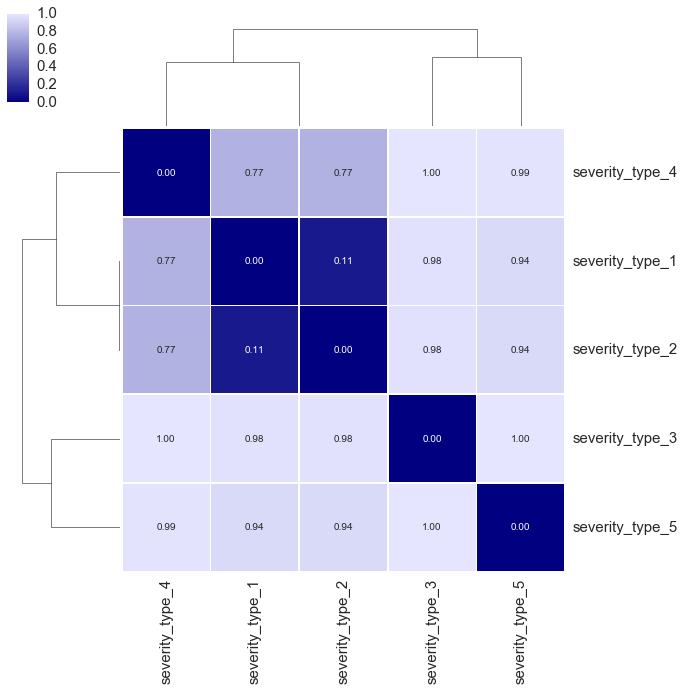

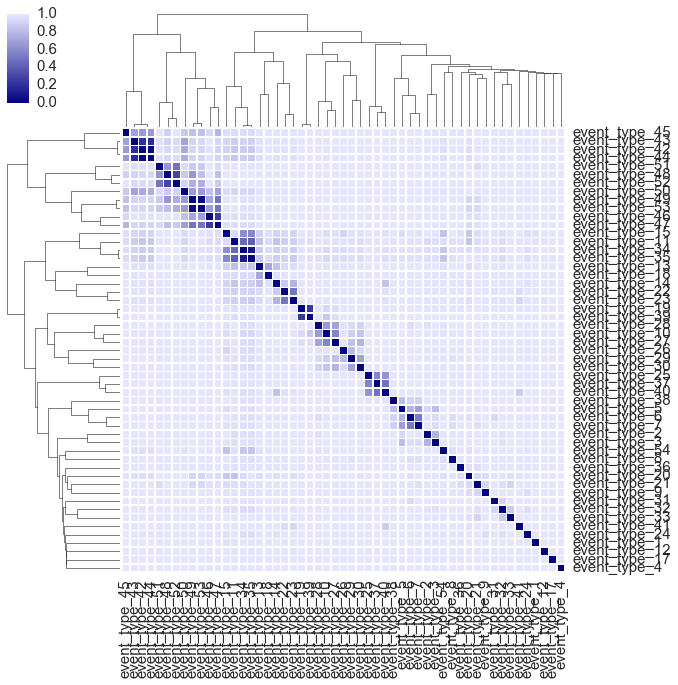

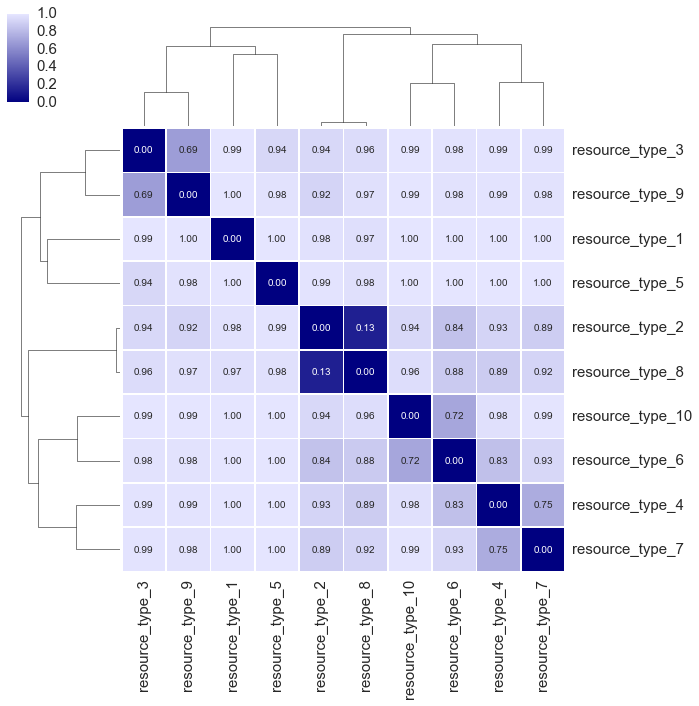

In [72]:
a = ['severity_type', 'event_type', 'resource_type']
for b in a:

    # correlation matrix
    c = df_all.filter(regex=b).copy()
    corr = c.corr(min_periods=len(c.columns)/10)

    # colormap
    cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
    
    # clustered heatmap of distances w/o mask
    # dist 0 --> close, 1 --> distant
    dsim = 1.0-np.abs(corr)
    
    # find degenerate params
    mask = np.ones(dsim.shape,dtype='bool')
    mask[np.triu_indices(len(dsim))] = False
    x = ((dsim < 0.2) & mask).values.nonzero()
    a = zip(x[0], x[1])
    for x, y in a:
        print dsim.index[x], dsim.columns[y]

    # plot matrix
    if len(dsim) > 10:
        annot=False
    else:
        annot=True
    plt.figure(figsize=(15, 12))
    g = sns.clustermap(data=dsim,
                       method='complete',
                       metric='correlation',
                       cmap=cmap, linewidths=0.5, vmin=0.0, vmax = 1.0,
                       annot=annot, fmt='.2f', annot_kws={'size':'10'})
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [73]:
# log_feature specific
c = df_all.filter(regex='log_feature').copy()
log_corr = c.corr(min_periods=len(c.columns)/10)
log_dsim = 1.0-np.abs(log_corr)

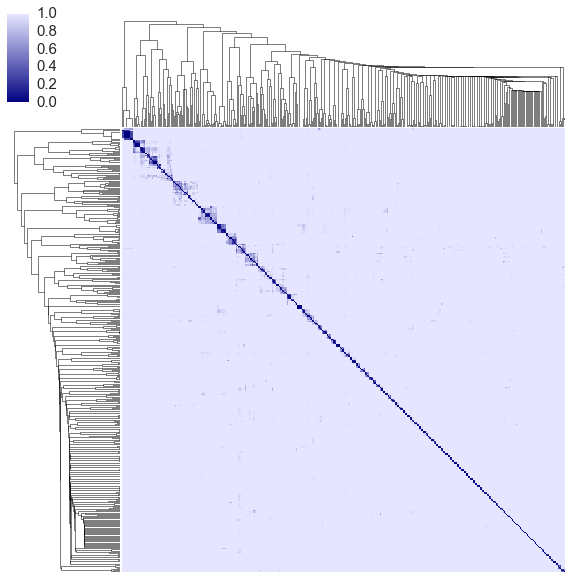

In [74]:
cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
g = sns.clustermap(data=log_dsim,
                   method='complete',
                   metric='correlation',
                   cmap=cmap,
                   xticklabels=False, yticklabels=False,
                   linewidths=0.0,
                   vmin=0.0,
                   vmax = 1.0)

The serverity types are mostly anti-correlated except type 1 and 2.

There is interesting structure in the resource and event types. Makes me more curious about how these events are networked, i.e. communicating to each other? Build out as network problem? Can't: id and loc are 1:1 so the only connections will be among events that are the same, in that they have the same coding across all types. I don't see that as informative to a model.

Log features are also clustered.

**But, this is clearly a well-defined classification problem.**

## Averages

In [13]:
df = df_all[(df_all.is_train==True)].copy()

In [14]:
sorted(df.fault_severity.unique())

[0.0, 1.0, 2.0]

In [15]:
names = []
pers = []
avgs = []
stds = []
for a in attributes:
    cnt = len(a)
    for c in filter(lambda s: s[:cnt] == a, df.columns):
        d = df[(df[c]>0)]
        names.append(c)
        pers.append(100.*float(d.shape[0])/float(df.shape[0]))
        avgs.append(d.fault_severity.mean())
        stds.append(d.fault_severity.std())

In [16]:
fs = pd.DataFrame({'%tot':pers, 'avg':avgs, 'std':stds}, index=names).fillna(0)

In [17]:
fsv = [0, 1, 2]
cnt = 0
drop_cols = {}
for n in fsv:
    a = fs[(fs['avg']==n) & (fs['std']==0)]
    drop_cols[str(n)] = list(a.index)
    cnt += a.shape[0]
    print n, a.shape[0]
print "Drop ", cnt, " of ", fs.shape[0]
print "Keeping ", fs.shape[0]-cnt, " columns"

0 136
1 32
2 24
Drop  192  of  454
Keeping  262  columns


So there are 192 attributes with a set fault severity value and standard dev of zero. So what if I build a model for events where all those features are 0 with those features dropped. So the fitting logic then becomes:

```python
known_fs = {}
for fs, cols in drop_col.iteritems():
    for col in cols:
        for id in df[df[col] > 0]['id']:
            known_fs[id] = fs        
df = pd.get_dummies(known_fs)
```

# Culling

In [18]:
df_culled = df_all.copy()
for k, v in drop_cols.iteritems():
    for c in v:
        df_culled = df_culled[df_culled[c] == 0]
        df_culled.drop(c, 1, inplace=True)
print "Removed ", df_all.shape[0] - df_culled.shape[0], " rows"
print "Dropped ", df_all.shape[1] - df_culled.shape[1], " cols"

Removed  569  rows
Dropped  192  cols


In [20]:
hdf = pd.HDFStore(hdf_file)
hdf.put('df_culled', df_culled)
hdf.close()

In [21]:
known_fs = {}
for fs, cols in drop_cols.iteritems():
    for col in cols:
        for id in df_all[(df_all[col] > 0) & (df_all.is_train==False)]['id']:
            known_fs[id] = fs
df_known = pd.Series(known_fs, name='predict')
df_known.index.name = 'id'
df_known = pd.get_dummies(df_known, prefix='predict').reset_index()

In [22]:
df_known.head()

,id,predict_0,predict_1,predict_2
0,78,0,0,1
1,128,1,0,0
2,150,0,1,0
3,208,1,0,0
4,215,0,0,1


In [23]:
check = df_known['id'].head()
for a in check:
    print known_fs[a]

2
0
1
0
2


In [24]:
hdf = pd.HDFStore(hdf_file)
hdf.put('df_known', df_known)
hdf.close()

**NB: in the end, the shapes of culled+known = df_all**

In [25]:
assert df_known.shape[0] + df_culled[(df_culled.is_train==False)].shape[0] == df_all[(df_all.is_train==False)].shape[0], "this is wrong"

The known fault severity values are now stored in df_known in the hdf5, so let's predict the ones we don't know. K.I.S.S. == random forest. 

# XGBoost

In [26]:
X_train = df_culled[(df_culled.is_train==True)]
y_train = X_train.fault_severity
X_train.drop(attribute_drop, 1, inplace=True)
X_test = df_culled[(df_culled.is_train==False)].drop(attribute_drop, 1)

assert df_all.drop(attribute_drop,1).shape[1] == 454, "df_all cols wrong"
assert X_train.shape[1] == 262, "train cols wrong"
assert X_test.shape[1] == 262, "test cols wrong"

In [40]:
clf = MyXGBClassifier(n_rounds=100,
                      eta=0.1,
                      max_depth=10,
                      subsample=0.9,
                      colsample_bytree=0.9,
                      booster='gbtree',
                      objective='multi:softprob',
                      num_class=3,
                      eval_metric='mlogloss',
                      nthread=4,
                      silent=0)

param = {'n_rounds':[100, 250, 500],
         'eta':[0.05, 0.1, 0.2],
         'max_depth': [5, 10, 20],
         'lambda': [0.9, 0.99],
         'alpha': [0.9,0.99],
         'subsample': [0.9, 1.0],
         'colsample_bytree': [0.9, 1.0],
        }

clf = grid_search.GridSearchCV(clf, param, scoring=scorer_logloss, n_jobs=-1, cv=3, refit=True)

In [ ]:
X = X_train.as_matrix()
y = y_train.as_matrix().astype(int)
clf.fit(X, y)

In [ ]:
report(clf.grid_scores_)

In [ ]:
prob = clf.predict_proba(X_tes)

In [337]:
xgbc_prob = pd.DataFrame({
    'id': culled[(culled.is_train==False)]['id'].values,
    'predict_0': prob[:, 0],
    'predict_1': prob[:, 1],
    'predict_2': prob[:, 2]})

In [338]:
assert df_known.shape[0] + xgbc_prob.shape[0] == df_all[(df_all.is_train==False)].shape[0], "Doesn't add up"

In [353]:
submission = pd.concat([xgbc_prob, df_known])

In [354]:
submission.to_csv('xgbc_known.csv', index=False)

# Decision Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF
kwargs = {'n_estimators': 400,
          'min_samples_split': 9,
          'n_jobs': -1}
df_train = culled[(culled.is_train==True)]
results = feature_mixer(df_train, attributes, RF, **kwargs)

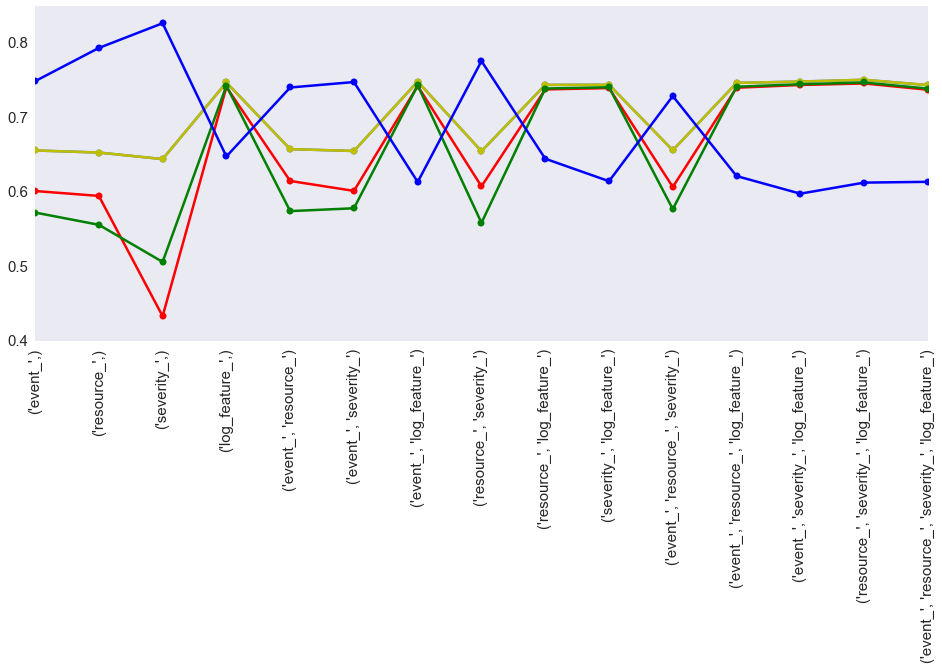

In [363]:
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
results.loc[:, 'accuracy'].plot(kind='line', ax=ax, rot=90, marker='o')
results.loc[:, 'precision'].plot(kind='line', ax=ax, color='r', rot=90, marker='o')
results.loc[:, 'recall'].plot(kind='line', ax=ax, color='y', rot=90, marker='o')
results.loc[:, 'f1'].plot(kind='line', ax=ax, color='g', rot=90, marker='o')
results.loc[:, 'kscore'].plot(kind='line', ax=ax, color='b', rot=90, marker='o')
plt.xticks(range(len(results.index)), results.attr_combo)
plt.show()

# Scratch

In [ ]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train = bf.base_features(train)
test = bf.base_features(test)

train, test = bf.location_features(train, test, cutoff=5)
train, test = bf.dangerous_location(train, test)
train, test = bf.safe_event(train, test)
train, test = bf.event_severity(train, test)

In [ ]:
labels = train.fault_severity.values
test_ids = test['id']

train.drop(['id', 'fault_severity', 'location'], axis=1, inplace=True)
test.drop(['id', 'location'], axis=1, inplace=True)

train = train.fillna(0)
train = train.astype(float)

test = test.fillna(0)
test = test.astype(float)

In [ ]:
#ch2 = SelectKBest(chi2, k=500)
ch2 = GenericUnivariateSelect(score_func=chi2,
                              mode='percentile',
                              param=80)
train = ch2.fit_transform(train, labels)
test = ch2.transform(test)

model, predictions = xgboost_model(train, labels, test)

train_score = sc.multi_log_loss(
    model.predict(xgb.DMatrix(train)), labels
)
print('train score', train_score)

predictions_df = pd.DataFrame({
        'id': test_ids,
        'predict_0': predictions[:, 0],
        'predict_1': predictions[:, 1],
        'predict_2': predictions[:, 2]
    })
predictions_df.to_csv('{}_v{}.csv'.format('xgb', version),
                      index=False)